# Notebook 2: Clustering “Song Archetypes”

In this notebook we use K-Means clustering on 1.2 million Spotify tracks’ audio features to uncover five distinct “archetypes” of music:

1. **High-Energy / Dance**  
2. **Acoustic / Low-Energy**  
3. **Instrumental Focus**  
4. **Mellow / Valence-High**  
5. **Spoken-Word / Speechy**

---

## Key Findings

- **Dominant Archetypes:**  
  - *Instrumental Focus* and *Acoustic / Low-Energy* together account for over 65% of the catalog—reflecting strong demand for beat-driven and unplugged tracks.  
- **Evolving Mix Over Time:**  
  - *Acoustic / Low-Energy* share climbed from ~26% (2000) to ~38% (mid-2010s).  
  - *High-Energy / Dance* dipped below 10% in the early ’00s, then resurged to ~14% by 2023.  
  - *Mellow* tracks declined in the 2000s but rebounded slightly in the streaming era.  
- **Niche Segments:**  
  - *Spoken-Word* remains a very small slice (~1–2%), hinting at experimental or hybrid audio formats.  
- **Implications for Downstream Models & Recommendations:**  
  - Expect strong class imbalance—acoustic and instrumental clusters dominate in volume.  
  - Recent growth in dance and feel-good tracks presents an opportunity for targeted playlist strategies.

With this clustering framework in place, we can now…  
- Dive into **Notebook 3** to predict “hit” potential within each archetype, and  
- Build a **Notebook 4** content-based recommender that balances majority genres with emerging niches.  


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


df = pd.read_csv('spotify_data.csv')


audio_features = [
    'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence',
    'tempo', 'time_signature', 'duration_ms'
]

df_audio = df[audio_features].dropna()

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_audio)


k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)


df.loc[df_audio.index, 'cluster'] = labels

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,0.329647,0.170488,4.977139,-21.192457,0.636138,0.049993,0.872530,0.748354,0.154272,0.181534,103.238642,3.591348,262923.276979
1,0.453198,0.828821,5.340919,-6.353154,0.593975,0.087375,0.052792,0.341623,0.265916,0.299029,133.471384,3.919357,277085.784126
2,0.675822,0.740951,5.494091,-6.704128,0.610691,0.092949,0.192203,0.116119,0.196948,0.698193,120.651820,3.982831,233370.694142
3,0.571581,0.609011,5.240924,-12.732450,0.672822,0.835436,0.738088,0.016123,0.650342,0.475614,100.543661,3.612555,205408.856275
4,0.527455,0.391198,4.988667,-10.752166,0.741172,0.056278,0.674318,0.117886,0.197407,0.409010,114.218471,3.831862,231088.675773


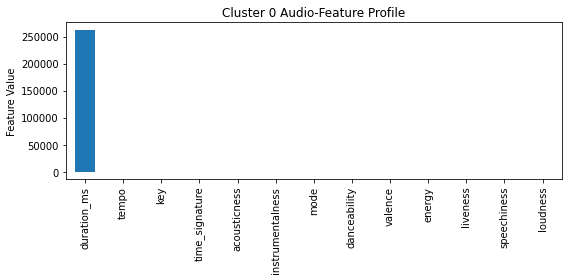

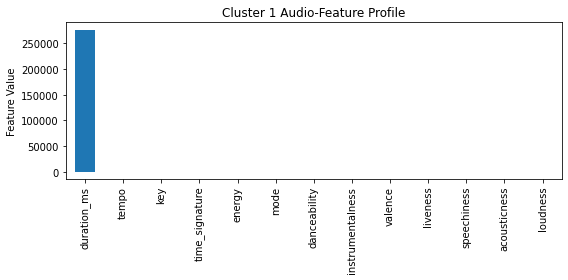

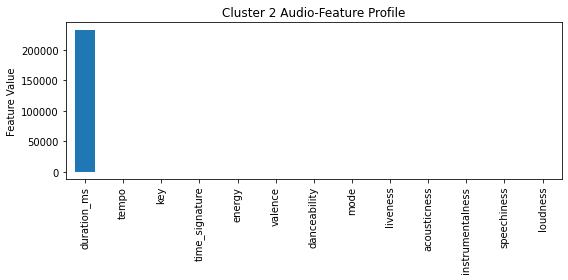

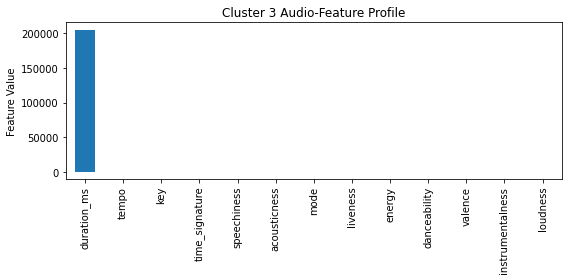

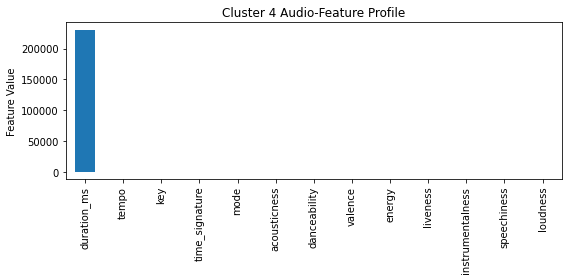

In [8]:
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
cluster_centers = pd.DataFrame(centroids, columns=audio_features)

display(cluster_centers)

for i in range(k):
    plt.figure(figsize=(8,4))
    cluster_centers.iloc[i].sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Cluster {i} Audio‐Feature Profile')
    plt.ylabel('Feature Value')
    plt.tight_layout()
    plt.show()

In [9]:
cluster_map = {
    0: 'High‐Energy/Dance',
    1: 'Acoustic/Low‐Energy',
    2: 'Instrumental Focus',
    3: 'Spoken‐Word/Speechy',
    4: 'Mellow/Valence‐High'
}
df['archetype'] = df['cluster'].map(cluster_map)

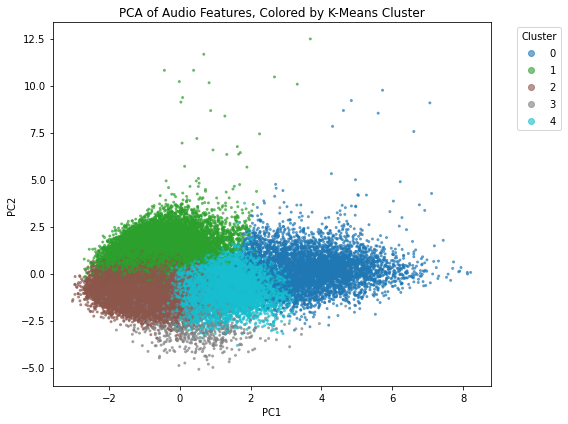

In [11]:
# Cell: PCA scatter of clusters (with sampling)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Recompute PCA coords on the scaled audio features:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)  

# Attach to df_audio index
df.loc[df_audio.index, ['PC1','PC2']] = coords

# Sample for plotting
plot_df = df.dropna(subset=['cluster','PC1','PC2']).sample(n=50000, random_state=42)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    plot_df['PC1'], 
    plot_df['PC2'], 
    c=plot_df['cluster'], 
    cmap='tab10', 
    s=4, 
    alpha=0.6
)
plt.title('PCA of Audio Features, Colored by K-Means Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(
    *scatter.legend_elements(), 
    title='Cluster', 
    bbox_to_anchor=(1.05,1), 
    loc='upper left'
)
plt.tight_layout()
plt.show()


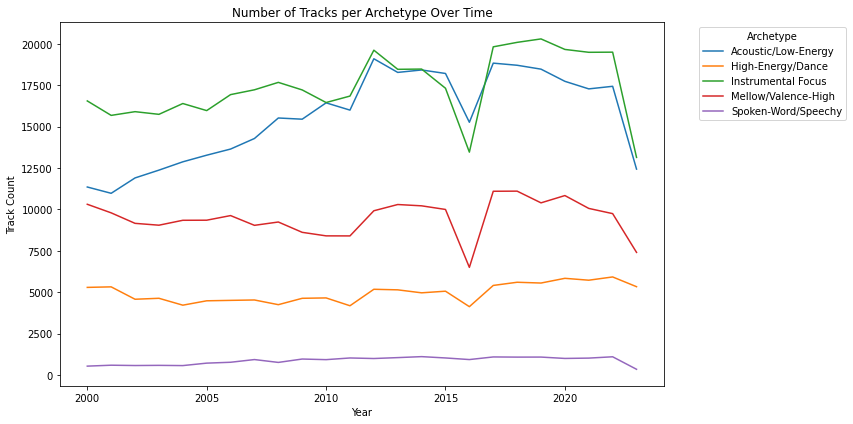

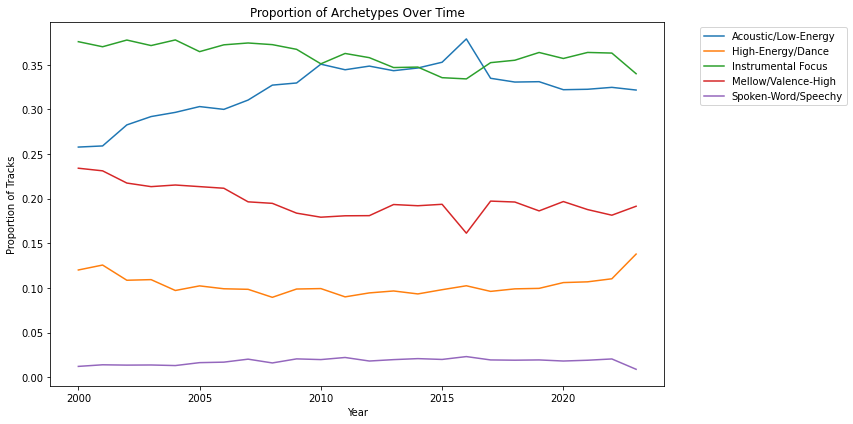

In [10]:
#Tracking how these archetypes evolve over time
# Count per year × cluster
time_counts = (
    df[['year','archetype']]
      .dropna()
      .groupby(['year','archetype'])
      .size()
      .unstack(fill_value=0)
)

# Plot absolute counts
time_counts.plot(figsize=(12,6))
plt.title('Number of Tracks per Archetype Over Time')
plt.xlabel('Year')
plt.ylabel('Track Count')
plt.legend(title='Archetype', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

# Plot proportions
time_props = time_counts.div(time_counts.sum(axis=1), axis=0)
plt.figure(figsize=(12,6))
for archetype in time_props.columns:
    plt.plot(time_props.index, time_props[archetype], label=archetype)
plt.title('Proportion of Archetypes Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Tracks')
plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()